In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./test_score.ipynb'))))

import numpy as np
import pandas as pd

from ylearn.estimator_model._generalized_forest.tree._grf_tree import GrfTree
from ylearn.estimator_model._generalized_forest._grf import GRForest
from ylearn.exp_dataset.exp_data import sq_data
from ylearn.utils._common import to_df
from ylearn.estimator_model._naive_forest.utils import grad, grad_coef, inverse_grad

from numpy.linalg import lstsq, inv

from copy import deepcopy


n = 2000
d = 10     
n_x = 1
y, x, v = sq_data(n, d, n_x)

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])
w = deepcopy(v)
v_test = v[:min(100, n)].copy()
v_test[:, 0] = np.linspace(np.percentile(v[:, 0], 1), np.percentile(v[:, 0], 99), min(100, n))
data = to_df(treatment=x, outcome=y, v=v)
test_data = to_df(v=v_test)

outcome = 'outcome'
treatment = 'treatment'
covariate = data.columns[2:]
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
# x = oh.fit_transform(x).toarray().astype(np.float32)



gtre = GrfTree(max_depth=100000, max_leaf_nodes=100000)
gtre._fit_with_array(x, y, w=None, v=v)
gtre.tree_.predict(v[:50].astype(np.float32)).squeeze()

array([ 0.07144379, -0.30602605,  1.71559724, -0.27135004, -0.10237191,
       -0.32924718,  0.21400034, -0.71116216,  2.80058766,  1.48035956,
        0.28154591, -0.11772502,  1.2836452 , -0.08198122, -0.08198122,
        0.13862856, -0.76625044, -0.08198122,  1.68117291,  1.53253659,
        1.32407611, -0.32020137,  2.20334568, -0.47967295,  1.05121514,
        5.33291398,  1.20370696,  0.00895498, -0.15195766, -0.6797273 ,
       -0.44083678,  2.62236404,  1.46047854, -0.10941884,  0.31452394,
        0.66291419, -0.27518667, -0.21910299,  0.05828689, -0.43389748,
        3.26893827,  1.31313758, -0.32924718, -0.29355244,  1.59054867,
        0.17651058,  1.20370696,  1.32407611, -0.08198122,  0.07648567])

In [2]:
grf = GRForest(
    n_jobs=1, 
    honest_subsample_num=None,
    min_samples_split=10, 
    sub_sample_num=0.5, 
    n_estimators=100, 
    random_state=2022, 
    min_impurity_decrease=1e-10, 
    max_depth=100, 
    max_leaf_nodes=100, 
    verbose=0,
)
grf.fit(
    data=data, outcome=outcome, treatment=treatment, covariate=covariate
)

In [3]:
effect = grf._prepare4est(test_data)

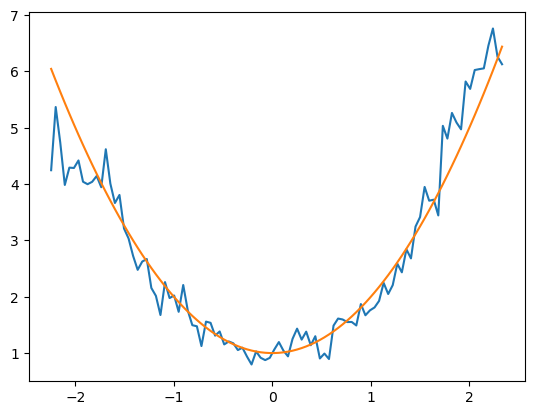

In [4]:
import matplotlib.pyplot as plt

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])

for t in range(n_x):
    plt.plot(v_test[:, 0], effect[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()

In [5]:
grf_honest = GRForest(
    n_jobs=1, 
    honest_subsample_num=0.35,
    min_samples_split=10, 
    sub_sample_num=0.75, 
    n_estimators=100, 
    random_state=2022, 
    min_impurity_decrease=1e-10, 
    max_depth=100, 
    max_leaf_nodes=100, 
    verbose=0,
)
grf_honest.fit(
    data=data, outcome=outcome, treatment=treatment, covariate=covariate
)

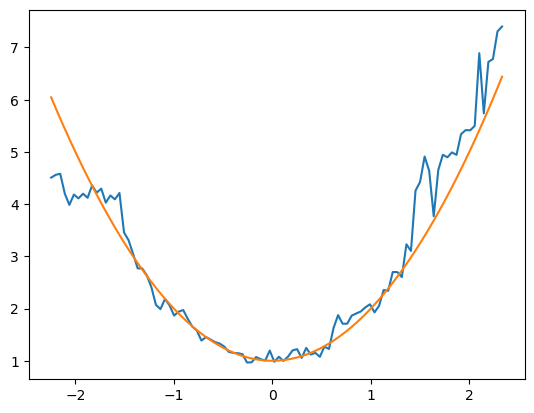

In [6]:
effect_honest = grf_honest._prepare4est(test_data)
for t in range(n_x):
    plt.plot(v_test[:, 0], effect_honest[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()